# Лабораторная работа 2. Метод ближайших соседей и решающие деревья.

ФИО: Копин Борис Александрович

Группа: 

In [338]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
import numpy as np
import time
import pandas as pd
from sklearn import metrics
from sklearn import neighbors
from sklearn import metrics
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [340]:
data = pd.read_csv('./amazon.csv')
data.head()


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [341]:
data.shape

(32769, 10)

In [342]:
# доля положительных примеров
data.ACTION.mean()

0.94210992096188473

In [343]:
# число значений у признаков
for col_name in data.columns:
    print col_name, len(data[col_name].unique())

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [344]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)
features = X_train.columns

In [345]:
y_train = y_train.astype('b')
y_test = y_test.astype('b')

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния (учитите, что он должен возвращать вероятность — отношение объектов первого класса среди соседей к числу соседей). Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba).

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

In [15]:
from collections import Counter


class KNeighborsClassifier(object):
    def __init__(self, X_train, y_train, dist_func='overlap', feature_weights=None, **kwargs):
        """
        Parameters
        ----------
        X : array, shape (n_objects, n_features)
            List of n_features-dimensional data points.  Each row
            corresponds to a single data point.
        """
        self._dist_func = dist_func

        self._X_train = X_train
        self._y_train = y_train
        self._sorted_neighbors = None

        self.classes = set(self._y_train)
        self.feature_weights = feature_weights or np.ones(self._X_train.shape[1])

    def fit(self, X_pred):
        print "Find coincidence features"
        coincidence_matrix = X_pred[:, np.newaxis] == self._X_train[np.newaxis, :]

        print "Compute dist(self._X_train, X_pred)"
        dist_func = _dist_funcs_dict[self._dist_func]
        dist_matrix = dist_func(self, X_pred, coincidence_matrix)

        print "Get class indices"
        nearest_X_train_indices = np.argsort(dist_matrix, axis=1)

        print "Sort and save neighbors"
        self._sorted_neighbors_idxs = self._y_train[nearest_X_train_indices]

    def predict(self, k):
        k_nearest_neighbors = self._sorted_neighbors_idxs[:, :k]

        score = np.array([np.sum(k_nearest_neighbors == c, axis=1) for c in self.classes]).T
        X_y = np.argmax(score, axis=1)

        return X_y

    def _load_sorted_neighbors_idxs(self, sorted_neighbors_idxs):
        self._sorted_neighbors_idxs = sorted_neighbors_idxs


def _overlap_dist(KNN, X_pred, coincidence_matrix):
    print "_overlap_dist"
    print "Inverting coincidence_matrix"
    inv_coincidence_matrix = np.invert(coincidence_matrix.astype(bool))
    weighted_coincidence_matrix = inv_coincidence_matrix * KNN.feature_weights

    print "Sum Feature distance"
    dist_matrix = np.sum(weighted_coincidence_matrix, axis=2)

    return dist_matrix


def _get_accumulated_p_2(f, l):
    print "_get_accumulated_p_2"
    p = [Counter({v: f_v / float(l) for v, f_v in c.items()}) for c in f]
    p_2 = [Counter({v: f_v * (f_v - 1) / float(l * (l - 1)) for v, f_v in c.items()}) for c in f]

    A_dtype = [('x', int), ('p', float), ('p2', float)]
    A_order = 'p'
    A = []
    for i, c in enumerate(f):
        u = np.array([(k, p[i].get(k), p_2[i].get(k)) for k in c.keys()], dtype=A_dtype)
        u.sort(order=A_order)
        A.append(np.array(u.tolist()[::-1]))

    # cumulative sum over p_2
    B = [np.column_stack([f_A, np.cumsum(f_A, axis=0)[:, 2]]) for f_A in A]

    # extract p_2 only
    P_2 = [Counter({int(x): f_B[i, 3] for i, x in enumerate(f_B[:, 0])}) for f_B in B]

    return P_2


def _smooth_overlap_dist(KNN, X_pred, coincidence_matrix):
    print "_smooth_overlap_dist"
    f = [Counter(c) for c in KNN._X_train.T]

    accum_p_2 = _get_accumulated_p_2(f, KNN._X_train.shape[0])

    # Extend each X 
    print "Extend each X "
    X_accum_p_2 = [[accum_p_2[i].get(feature) for i, feature in enumerate(x)] for x in KNN._X_train]
    X_accum_p_2 = np.array(X_accum_p_2)

    print "Get P_2"
    idx_coincidence_features = np.nonzero(coincidence_matrix)
    X_coincidence_idx = (idx_coincidence_features[1], idx_coincidence_features[2])

    print "Feature distance"
    dist_matrix = np.ones((X_pred.shape[0], KNN._X_train.shape[0], KNN._X_train.shape[1]))
    dist_matrix[idx_coincidence_features] = X_accum_p_2[X_coincidence_idx]

    print "Sum Feature distance"
    dist_matrix_sum = np.sum(dist_matrix, axis=2)

    return dist_matrix_sum


def _map_to_log_f(x):
    print "_map_to_log_f"
    f_x = [Counter(c) for c in x.T]
    log_f_x = [Counter({v: np.log(c) for v, c in f.items()}) for f in f_x]
    x_log_f = [[log_f_x[f_i].get(f) for f_i, f in enumerate(obj)] for obj in x]
    return np.array(x_log_f)


def _type3_dist(KNN, X_pred, coincidence_matrix):
    print "_type3_dist"
    fit_X_log_f = _map_to_log_f(KNN._X_train)
    X_log_f = _map_to_log_f(X_pred)

    print "np.dot(X_log_f, fit_X_log_f.T)"
    a_b_f = np.dot(X_log_f, fit_X_log_f.T)

    x = KNN._X_train
    y = X_pred
    A = coincidence_matrix

    print "Step 1"
    A_x = A.reshape(y.shape[0], x.size) * fit_X_log_f.reshape(1, x.size)
    A_x = A_x.reshape(y.shape[0], x.shape[0], x.shape[1])

    print "Step 2"
    A_x_T = A_x.swapaxes(0, 1)
    A_x_T_slab = A_x_T.reshape(len(x), len(y) * x.shape[1])

    print "Step 3"
    A_x_y_T_slab = A_x_T_slab * X_log_f.reshape(1, y.size)

    print "Step 4"
    A_x_y_T = A_x_y_T_slab.reshape(len(x), len(y), x.shape[1])
    A_x_y = A_x_y_T.swapaxes(1, 0)

    print "Step 5"
    A_x_y_sum = np.sum(A_x_y, axis=2)

    print "Step 6"
    dist_matrix = a_b_f - A_x_y_sum

    return dist_matrix


_dist_funcs_dict = {
    'overlap': _overlap_dist,
    'smooth_overlap': _smooth_overlap_dist,
    'type3': _type3_dist,
}


## Overlap dist

In [99]:
knn_overlap = KNeighborsClassifier(X_train.as_matrix(), y_train.as_matrix(), dist_func="overlap")

In [100]:
%time knn_overlap.fit(X_test.as_matrix())

Find coincidence features
Compute dist(self._X_train, X_pred)
_overlap_dist
Inverting coincidence_matrix
Sum Feature distance
Get class indices
Sort and save neighbors
CPU times: user 23.8 s, sys: 50.2 s, total: 1min 14s
Wall time: 1min 24s


In [101]:
y_pred = knn_overlap.predict(k=2)
metrics.roc_auc_score(y_test, y_pred)

0.7720236054232521

In [115]:
# Save overlap_neighbors_idxs
np.savez("files/overlap_neighbors_idxs.dat",
         overlap_neighbors_idxs=knn_overlap._sorted_neighbors_idxs)

## Smooth overlap

In [120]:
knn_smooth_overlap = KNeighborsClassifier(X_train.as_matrix(), y_train.as_matrix(), dist_func="smooth_overlap")

In [121]:
%time knn_smooth_overlap.fit(X_test.as_matrix())

Find coincidence features
Compute dist(self._X_train, X_pred)
_smooth_overlap_dist
_get_accumulated_p_2
Extend each X 
Get P_2
Feature distance
Sum Feature distance
Get class indices
Sort and save neighbors
CPU times: user 41.4 s, sys: 1min 21s, total: 2min 2s
Wall time: 2min 35s


In [123]:
y_pred = knn_smooth_overlap.predict(k=2)
metrics.roc_auc_score(y_test, y_pred)

0.76445255301300175

In [125]:
# Save overlap_neighbors_idxs
np.savez("files/smooth_overlap_neighbors_idxs.dat",
         smooth_overlap_neighbors_idxs=knn_smooth_overlap._sorted_neighbors_idxs)

## Type3

In [126]:
knn_type3 = KNeighborsClassifier(X_train.as_matrix(), y_train.as_matrix(), dist_func="type3")

In [127]:
%time knn_type3.fit(X_test.as_matrix())

Find coincidence features
Compute dist(self._X_train, X_pred)
_type3_dist
_map_to_log_f
_map_to_log_f
np.dot(X_log_f, fit_X_log_f.T)
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Get class indices
Sort and save neighbors
CPU times: user 1min 22s, sys: 1min 43s, total: 3min 6s
Wall time: 4min 16s


In [129]:
y_pred = knn_type3.predict(k=2)
metrics.roc_auc_score(y_test, y_pred)

0.73368150577843338

In [130]:
# Save overlap_neighbors_idxs
np.savez("files/type3_neighbors_idxs.dat",
         type3_neighbors_idxs=knn_type3._sorted_neighbors_idxs)

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

### overlap_neighbors

In [16]:
overlap_neighbors_idxs = np.load('files/overlap_neighbors_idxs.dat.npz')['overlap_neighbors_idxs']

In [17]:
o_knn = KNeighborsClassifier(X_train.as_matrix(), y_train.as_matrix(), dist_func="overlap")
o_knn._load_sorted_neighbors_idxs(overlap_neighbors_idxs)

In [22]:
o_knn_score = np.array([metrics.roc_auc_score(y_test, o_knn.predict(k=k)) for k in range(1, 16)])
print "k =", np.argmax(o_knn_score) + 1, "| roc_auc_score =", max(o_knn_score)

k = 2 | roc_auc_score = 0.772023605423


## smooth_overlap_neighbors

In [24]:
smooth_overlap_neighbors_idxs = np.load('files/smooth_overlap_neighbors_idxs.dat.npz')['smooth_overlap_neighbors_idxs']

In [25]:
so_knn = KNeighborsClassifier(X_train.as_matrix(), y_train.as_matrix(), dist_func="smooth_overlap")
so_knn._load_sorted_neighbors_idxs(smooth_overlap_neighbors_idxs)

In [26]:
so_knn_score = np.array([metrics.roc_auc_score(y_test, so_knn.predict(k=k)) for k in range(1, 16)])
print "k =", np.argmax(so_knn_score) + 1, "| roc_auc_score =", max(so_knn_score)

k = 2 | roc_auc_score = 0.764452553013


## Type3 

In [31]:
type3_neighbors_idxs = np.load('files/type3_neighbors_idxs.dat.npz')['type3_neighbors_idxs']

In [32]:
t3_knn = KNeighborsClassifier(X_train.as_matrix(), y_train.as_matrix(), dist_func="type3")
t3_knn._load_sorted_neighbors_idxs(type3_neighbors_idxs)

In [33]:
t3_knn_score = np.array([metrics.roc_auc_score(y_test, t3_knn.predict(k=k)) for k in range(1, 16)])
print "k =", np.argmax(t3_knn_score) + 1, "| roc_auc_score =", max(t3_knn_score)

k = 2 | roc_auc_score = 0.733681505778


 **Вывод:  Наилучшее качество достигается на smooth_overlap_neighbors с k = 2. **

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

<span style="color:blue">1. Считаем счетчики</span>

In [39]:
def counts_and_clicks(X, y):
    counts_dict = {col: dict(Counter(X[col])) for col in X.columns}
    clicks_dict = {col: dict(Counter(X[y == 1][col])) for col in X.columns}
    
    return counts_dict, clicks_dict

<span style="color:blue">2. Функции по переводу DataFrame-ов в счетчики</span>

In [40]:
def to_counts_using_replace(X):
    X_counts = X.replace(to_replace=counts_dict)
    X_counts.columns += "_counts"
    
    X_clicks = X.replace(to_replace=clicks_dict)
    X_clicks.columns += "_clicks"
    
    X_smooth = X.replace(to_replace=smooth_dict)
    X_smooth.columns += "_smooth"
    
    X_c_train = pd.concat([X_counts, X_clicks, X_smooth], axis=1)

    return X_c_train

def categorial_to_counts(X, counts_dict, clicks_dict):
    new_series = []

    for col in X.columns:
        counts = X[col].apply(lambda x: counts_dict[col].get(x, 0))
        counts.name += '_counts'

        clicks = X[col].apply(lambda x: clicks_dict[col].get(x, 0))
        clicks.name += '_clicks'

        smooth = (clicks + 1) / (counts + 2).astype(float)
        smooth.name = col + '_smooth'

        new_series += [counts, clicks, smooth]

    X_counts = pd.concat(new_series, axis=1)
    
    return X_counts

In [41]:
def convert_2_counts(X, y, folds=1):
    X_counted = None
    
    if folds > 1:
        X_folds = np.array_split(X, folds)
        y_folds = np.array_split(y, folds)
    
        counted_folds = []
        for fold_num in range(folds):
            X_rest_folds = pd.concat([X_folds[i] for i in range(folds) if i != fold_num])
            y_rest_folds = pd.concat([y_folds[i] for i in range(folds) if i != fold_num])
            
            counts, clicks = counts_and_clicks(X_rest_folds, y_rest_folds)
            X_fold_counted = categorial_to_counts(X_folds[fold_num], counts, clicks)

            counted_folds.append(X_fold_counted)

        X_counted = pd.concat(counted_folds)
    else:
        counts, clicks = counts_and_clicks(X, y)
        X_counted = categorial_to_counts(X, counts, clicks)
    
    return X_counted

In [42]:
def convert_2_counts_with_counts(X, counts, clicks):
    X_counted = categorial_to_counts(X, counts, clicks)
    return X_counted

In [43]:
normalize = lambda X: (X - X.mean()) / (X.max() - X.min())

In [121]:
def categorial_to_real(X_train, y_train, X_test, folds=1):
    # Convert X_train categorial to real
    X_train_real = convert_2_counts(X_train, y_train, folds=folds)
    
    # Get counts of all X_train for X_test
    counts, clicks = counts_and_clicks(X_train, y_train)
    
    # Convert X_test categorial to real
    X_test_real = convert_2_counts_with_counts(X_test, counts, clicks)
    
    return X_train_real, X_test_real

_

In [44]:
X_c_train = convert_2_counts(X_train, y_train, folds=3)

X_train_counts, X_train_clicks = counts_and_clicks(X_train, y_train)
X_c_test = convert_2_counts_with_counts(X_test, X_train_counts, X_train_clicks)


<span style="color:blue">3. Запускаеи KNN</span>

In [45]:
def count_clicks_simple_test(X_train, y_train, X_test, y_test):
    X_train_real, X_test_real = categorial_to_real(X_train, y_train, X_test, folds=3)

    clf_euclidean = neighbors.KNeighborsClassifier(n_neighbors=2)
    clf_euclidean.fit(normalize(X_train_real), y_train) 
    y_pred = clf_euclidean.predict(normalize(X_test_real))
    return metrics.roc_auc_score(y_test, y_pred)

0.71496737163769364

In [ ]:
count_clicks_simple_test(X_train, y_train, X_test, y_test)

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [46]:
def convert_to_real_and_compute_auc_roc(X_train, y_train, X_test, y_test, with_folding=False):
    if with_folding:
        print "--> AUC-ROC с фолдингом"
        folds=3
    else:
        print "--> AUC-ROC без фолдингом"
        folds=1

    print "- Converting X_train to counts"
    X_train_real = convert_2_counts(X_train, y_train, folds=folds)

    print "- Converting X_test to counts"
    X_train_counts, X_train_clicks = counts_and_clicks(X_train, y_train)
    X_test_real = convert_2_counts_with_counts(X_test, X_train_counts, X_train_clicks)
    
    print "- Fitting clf"
    clf = neighbors.KNeighborsClassifier(n_neighbors=2)
    clf.fit(normalize(X_train_real), y_train) 
    
    print "- Predicting"
    y_pred = clf.predict(normalize(X_test_real))
    
    score = metrics.roc_auc_score(y_test, y_pred)
    print "AUC-ROC=%f" % score
    
    return X_train_real, X_test_real

In [47]:
convert_to_real_and_compute_auc_roc(X_train, y_train, X_test, y_test, with_folding=False);
X_train_real, X_test_real = convert_to_real_and_compute_auc_roc(X_train, y_train, X_test, y_test, with_folding=True);

--> AUC-ROC без фолдингом
- Converting X_train to counts
- Converting X_test to counts
- Fitting clf
- Predicting
AUC-ROC=0.713071
--> AUC-ROC с фолдингом
- Converting X_train to counts
- Converting X_test to counts
- Fitting clf
- Predicting
AUC-ROC=0.714967


In [134]:
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV

n_neighbors_range = range(2, 4)

def knn_select_best_k(X_train, y_train):
    cv = KFold(X_train.shape[0], shuffle=True, n_folds=5)
    gs = GridSearchCV(neighbors.KNeighborsClassifier(),
                      param_grid={'n_neighbors': n_neighbors_range},
                      cv=cv,
                      scoring='roc_auc')
    gs.fit(normalize(X_train), y_train)
    
    print gs.grid_scores_
    plt.scatter(n_neighbors_range,
                [gs.grid_scores_[i].mean_validation_score for i in range(len(gs.grid_scores_))])
    
    return gs

In [84]:
%time gs = knn_select_best_k(X_train_real, y_train)

CPU times: user 1min 35s, sys: 379 ms, total: 1min 35s
Wall time: 1min 35s


In [103]:
def evaluate(X_train, y_train, X_test, y_test, k):
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(normalize(X_train), y_train)

    y_pred = clf.predict(normalize(X_test))

    print metrics.roc_auc_score(y_test, y_pred)
    
evaluate(X_train_real, y_train, X_test_real, y_test, 4)

0.676446549222


Оптимальное k = 4

**Вывод: Данный Категориальный Training set, преобразованный в счетчики с фолдингом дает незначительный прирост качества, по сравнению с преобразованием без фолдинга.**

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [107]:
import itertools

In [108]:
X_train.columns

Index([u'RESOURCE', u'MGR_ID', u'ROLE_ROLLUP_1', u'ROLE_ROLLUP_2',
       u'ROLE_DEPTNAME', u'ROLE_TITLE', u'ROLE_FAMILY_DESC', u'ROLE_FAMILY',
       u'ROLE_CODE'],
      dtype='object')

In [129]:
def expand_df(X):
    df = X.copy()
    col_combs = itertools.combinations(df.columns, r=2)
    for col1, col2 in col_combs:
        s1 = df.loc[:, col1]
        s2 = df.loc[:, col2]
        
        new_col = s1.name + '_and_'+ s2.name
        df[new_col] = s1 + s2
    
    return df

* X_train_expand - **X_train с парными признаками**
* X_test_expand  - **X_test  с парными признаками**

In [130]:
X_train_expand = expand_df(X_train)
X_test_expand = expand_df(X_test)

* X_train_expand_real - **ковертированный X_train_expand в счетчики без фолдинга**
* X_test_expand_real  - **ковертированный X_test_expand в счетчики без фолдинга**
* X_train_expand_real_fol - **ковертированный X_train_expand в счетчики c фолдингом**
* X_test_expand_real_fol  - **ковертированный X_test_expand в счетчики c фолдингом**

In [131]:
X_train_expand_real, X_test_expand_real = categorial_to_real(X_train_expand, y_train, X_test_expand, folds=1)
X_train_expand_real_fol, X_test_expand_real_fol = categorial_to_real(X_train_expand, y_train, X_test_expand, folds=5)

In [132]:
%time evaluate(X_train_expand_real, y_train, X_test_expand_real, y_test, 4)

0.630643919544
CPU times: user 37.1 s, sys: 181 ms, total: 37.3 s
Wall time: 37.3 s


In [133]:
%time evaluate(X_train_expand_real_fol, y_train, X_test_expand_real_fol, y_test, 4)

0.702134914936
CPU times: user 31.8 s, sys: 203 ms, total: 32 s
Wall time: 32.1 s


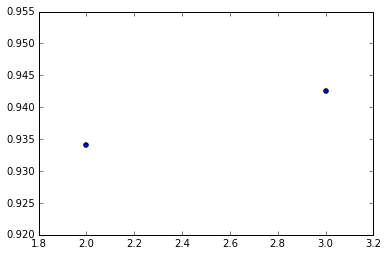

In [135]:
gs = knn_select_best_k(X_train_expand_real, y_train)

**Вывод: Категориальный Training set с конкатенацией признаков, преобразованный в счетчики с фолдингом дает прирост качества.**

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга (X_train_expand_real). Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

X_train_expand_real

In [147]:
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV


def trees__simple_clf(max_depth=None, min_samples_leaf=1):
    cv = KFold(X_train_expand_real.shape[0], shuffle=True, random_state=88, n_folds=5)
    clf = tree.DecisionTreeClassifier(random_state=88,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf)
    print cross_val_score(clf, X_train_expand_real, y_train, cv=cv, 
                           scoring='roc_auc').mean()

def trees__fit_params(X_train, y_train):    
    cv = KFold(X_train.shape[0], shuffle=True, random_state=241, n_folds=5)

    gs = GridSearchCV(tree.DecisionTreeClassifier(random_state=241),
                      param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 50],
                                  'min_samples_leaf': range(1, 20)},
                      cv=cv,
                      scoring='roc_auc')
    gs.fit(X_train, y_train)
    return gs

In [172]:
trees__simple_clf()

0.986247267747


In [311]:
def trees__evaluate_params(X_train, X_test, max_depth=None, min_samples_leaf=1):   
    clf = tree.DecisionTreeClassifier(random_state=88, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return metrics.roc_auc_score(y_test, y_pred)

### Стандартный датасет

In [307]:
gs = trees__fit_params(X_train, y_train)

(0.52776935469221331, 0.79329012674163557)

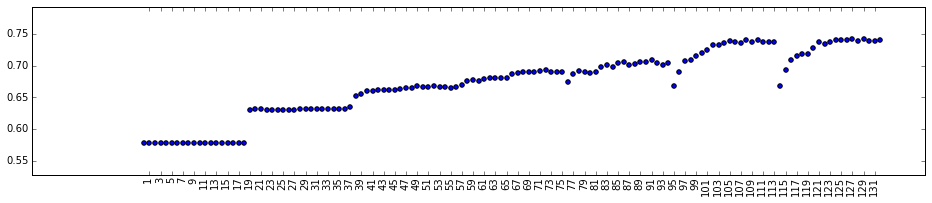

In [308]:
plt.figure(figsize=(16, 3))
means = [gs.grid_scores_[i].mean_validation_score for i in range(len(gs.grid_scores_))]
plt.scatter(range(len(gs.grid_scores_)), means)
plt.xticks(range(1, len(gs.grid_scores_), 2), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05])

In [316]:
print gs.grid_scores_[116]
print gs.grid_scores_[96]
print gs.grid_scores_[121]
print gs.grid_scores_[19]


mean: 0.70995, std: 0.01758, params: {'max_depth': 50, 'min_samples_leaf': 3}
mean: 0.69000, std: 0.01965, params: {'max_depth': 20, 'min_samples_leaf': 2}
mean: 0.73723, std: 0.00737, params: {'max_depth': 50, 'min_samples_leaf': 8}
mean: 0.63076, std: 0.00971, params: {'max_depth': 4, 'min_samples_leaf': 1}


In [317]:
print trees__evaluate_params(X_train_expand_real, X_test_expand_real, **gs.grid_scores_[116].parameters)
print trees__evaluate_params(X_train_expand_real, X_test_expand_real, **gs.grid_scores_[96].parameters)
print trees__evaluate_params(X_train_expand_real, X_test_expand_real, **gs.grid_scores_[121].parameters)
print trees__evaluate_params(X_train_expand_real, X_test_expand_real, **gs.grid_scores_[19].parameters)

0.562979694074
0.556452943346
0.542344087969
0.54868348979


### Деревья на датасете без фолдингом

In [150]:
gs = trees__fit_params(X_train_expand_real, y_train)

(0.93644928166517649, 1.0485824637030814)

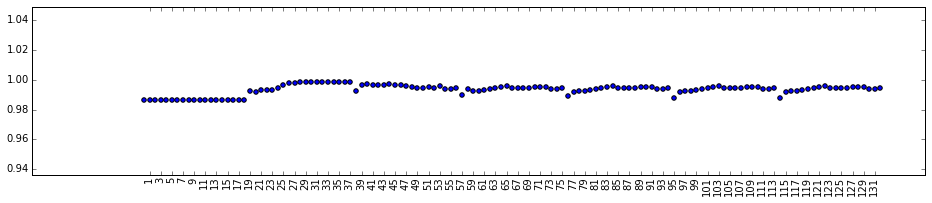

In [166]:
plt.figure(figsize=(16, 3))
means = [gs.grid_scores_[i].mean_validation_score for i in range(len(gs.grid_scores_))]
plt.scatter(range(len(gs.grid_scores_)), means)
plt.xticks(range(1, len(gs.grid_scores_), 2), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05])

(0.93644928166517649, 1.0485824637030814)

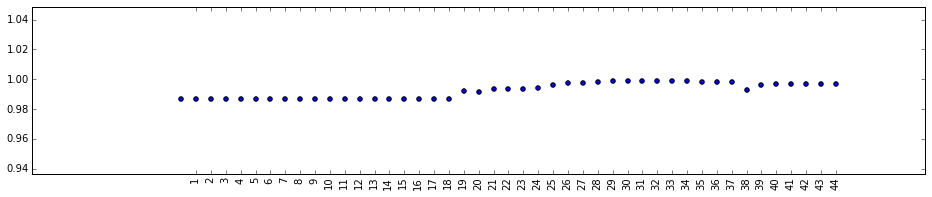

In [188]:
plt.figure(figsize=(16, 3))
scores = gs.grid_scores_[:45]

means = [scores[i].mean_validation_score for i in range(len(scores))]
plt.scatter(range(len(scores)), means)
plt.xticks(range(1, len(scores)), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05])

In [189]:
print gs.grid_scores_[20]
print gs.grid_scores_[19]
print gs.grid_scores_[18]
print gs.grid_scores_[38]


mean: 0.99174, std: 0.00455, params: {'max_depth': 4, 'min_samples_leaf': 2}
mean: 0.99243, std: 0.00135, params: {'max_depth': 4, 'min_samples_leaf': 1}
mean: 0.98645, std: 0.00575, params: {'max_depth': 2, 'min_samples_leaf': 19}
mean: 0.99268, std: 0.00305, params: {'max_depth': 6, 'min_samples_leaf': 1}


In [202]:
print trees__evaluate_params(X_train_expand_real, X_test_expand_real, **{'max_depth': 6, 'min_samples_leaf': 1})
print trees__evaluate_params(X_train_expand_real_fol, X_test_expand_real_fol, **{'max_depth': 6, 'min_samples_leaf': 1})


0.554222278292
0.655335696895


In [194]:
gs.best_score_, gs.best_params_

(0.99858246370308135, {'max_depth': 4, 'min_samples_leaf': 12})

### Деревья на датасете с фолдингом

In [203]:
gs = trees__fit_params(X_train_expand_real_fol, y_train)

(0.54199691162109154, 0.85129639374976207)

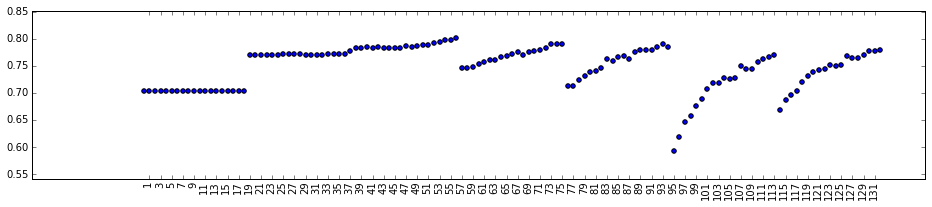

In [204]:
plt.figure(figsize=(16, 3))
means = [gs.grid_scores_[i].mean_validation_score for i in range(len(gs.grid_scores_))]
plt.scatter(range(len(gs.grid_scores_)), means)
plt.xticks(range(1, len(gs.grid_scores_), 2), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05])

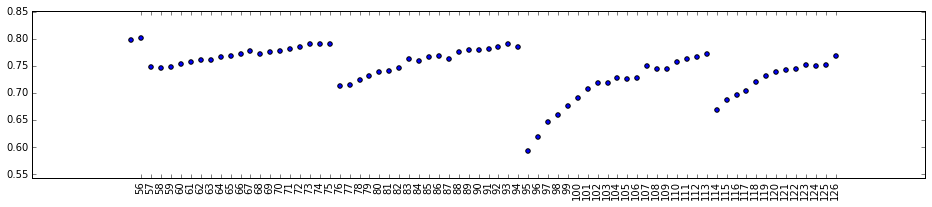

In [230]:
plt.figure(figsize=(16, 3))
scores = gs.grid_scores_[55:127]

means = [scores[i].mean_validation_score for i in range(len(scores))]
plt.scatter(range(len(scores)), means)
plt.xticks(range(1, len(scores)), range(56, 127), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05]);

In [227]:
for p in [56, 67, 68, 83, 88, 95, 96, 97, 107, 115, 126]:
    print p, trees__evaluate_params(X_train_expand_real_fol,
                             X_test_expand_real_fol,
                             **gs.grid_scores_[p].parameters)

56 0.647423103382
67 0.661552176266
68 0.657622970971
83 0.661823090874
88 0.649905813369
95 0.64316772229
96 0.669604944502
97 0.649485828336
107 0.646497141514
115 0.664323053135
126 0.646497141514


In [228]:
gs.best_score_, gs.best_params_

(0.80129639374976203, {'max_depth': 6, 'min_samples_leaf': 19})

In [231]:
trees__evaluate_params(X_train_expand_real_fol, X_test_expand_real_fol,
                         **{'max_depth': 6, 'min_samples_leaf': 19})

0.64742310338209252

**Вывод:**
* ** Деревья на счетчиках без фолдинга дают небольшой прирост, по сравнению с деревьями на категориальном датасете. **
* **Наилучший AUC-ROC на контроле - 0.99858246370308135, при параметрах {'max_depth': 4, 'min_samples_leaf': 12}. Из графиков видно, что деревья сильно переобучаются на кросс-валидации. Оптимальный набор параметров - gs.grid_scores_[38], {'max_depth': 6, 'min_samples_leaf': 1}**
* ** Качество классификации деревьев на счетчиках с фолдингом - лучше. **
* ** Деревья на счетчиках с фолдингом, по сравнению с деревьями на счетиках без фолдинга - нет так сильно переобучаются. **

#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [290]:
def randomforest__fit_params(X_train, y_train):    
    cv = KFold(X_train.shape[0], shuffle=True, random_state=241, n_folds=5)

    gs = GridSearchCV(RandomForestClassifier(random_state=88),
                      param_grid={'n_estimators': [10, 30, 50, 80, 100, 200, 300, 350, 400, 500]},
                      cv=cv,
                      scoring='roc_auc')
    gs.fit(X_train, y_train)
    return gs

In [291]:
randomforest_gs = randomforest__fit_params(X_train, y_train)

In [292]:
randomforest_gs.grid_scores_

[mean: 0.71715, std: 0.01100, params: {'n_estimators': 10},
 mean: 0.72883, std: 0.01177, params: {'n_estimators': 30},
 mean: 0.73697, std: 0.01139, params: {'n_estimators': 50},
 mean: 0.73949, std: 0.01028, params: {'n_estimators': 80},
 mean: 0.74032, std: 0.01030, params: {'n_estimators': 100},
 mean: 0.74062, std: 0.01061, params: {'n_estimators': 200},
 mean: 0.74215, std: 0.01193, params: {'n_estimators': 300},
 mean: 0.74271, std: 0.01163, params: {'n_estimators': 350},
 mean: 0.74275, std: 0.01185, params: {'n_estimators': 400},
 mean: 0.74331, std: 0.01177, params: {'n_estimators': 500}]

(0.667152855729639, 0.79331022844162247)

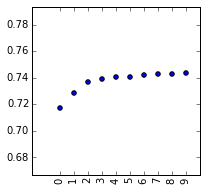

In [294]:
plt.figure(figsize=(3, 3))
scores = randomforest_gs.grid_scores_

means = [scores[i].mean_validation_score for i in range(len(scores))]
plt.scatter(range(len(scores)), means)
plt.xticks(range(0, len(scores)), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05])

In [299]:
randomforest_gs.grid_scores_[3]

mean: 0.73949, std: 0.01028, params: {'n_estimators': 80}

In [303]:
def randomforest__evaluate_params(X_train, X_test, n_estimators=100):   
    clf = RandomForestClassifier(random_state=88, n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return metrics.roc_auc_score(y_test, y_pred)

In [346]:
randomforest__evaluate_params(X_train, X_test, n_estimators=80)

0.69026508118272956

**Вывод: Случайный лес увеличивает качество классификации, по сравнению с Решающих деревом. AUC = 0.69**

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [324]:
def randomforest_real__fit_params(X_train, y_train):    
    cv = KFold(X_train.shape[0], shuffle=True, random_state=241, n_folds=5)

    gs = GridSearchCV(RandomForestClassifier(random_state=88),
                      param_grid={'n_estimators': [10, 30, 50, 80, 100, 200, 300, 350, 400, 500]},
                      cv=cv,
                      scoring='roc_auc')
    gs.fit(X_train, y_train)
    return gs

In [325]:
randomforest_real_gs = randomforest__fit_params(X_train_expand_real_fol, y_train)

In [328]:
randomforest_real_gs.grid_scores_

[mean: 0.84105, std: 0.01142, params: {'n_estimators': 10},
 mean: 0.84869, std: 0.01080, params: {'n_estimators': 30},
 mean: 0.84830, std: 0.01047, params: {'n_estimators': 50},
 mean: 0.84980, std: 0.00874, params: {'n_estimators': 80},
 mean: 0.85028, std: 0.00918, params: {'n_estimators': 100},
 mean: 0.85108, std: 0.00959, params: {'n_estimators': 200},
 mean: 0.85177, std: 0.00976, params: {'n_estimators': 300},
 mean: 0.85209, std: 0.00953, params: {'n_estimators': 350},
 mean: 0.85189, std: 0.00977, params: {'n_estimators': 400},
 mean: 0.85187, std: 0.00962, params: {'n_estimators': 500}]

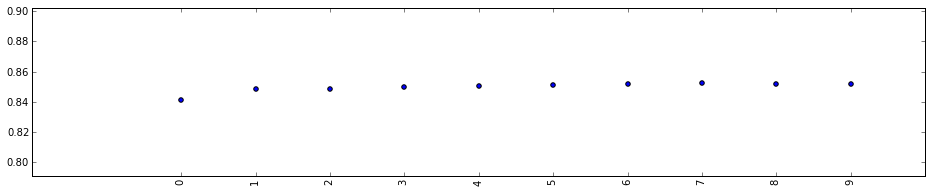

In [331]:
plt.figure(figsize=(16, 3))
scores = randomforest_real_gs.grid_scores_[:45]

means = [scores[i].mean_validation_score for i in range(len(scores))]
plt.scatter(range(len(scores)), means)
plt.xticks(range(0, len(scores)), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05]);

In [75]:
randomforest_fit_params(X_train_expand, y_train);

GridSearchCV(cv=sklearn.cross_validation.KFold(n=22938, n_folds=3, shuffle=True, random_state=241),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=241, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [1, 8, 15, 22, 29, 36, 43]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [348]:
randomforest__evaluate_params(X_train_expand_real_fol, X_test_expand_real_fol, **randomforest_real_gs.grid_scores_[1].parameters)

0.66078202399359942

**Вывод**:
* AUC на вещественных признаках с фолдингом = 0.66078202399359942. 
* *Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?*
    * Решающий Лес в sklearn не умеет строить предикаты на категориальных признаках, он воспринимает их как вещественные. Следовательно, целесообразно преобразовать категориальные признаки в вещественные и на них применять алгоритм.
    * С другой стороны, по результатам экспериментов применения Решающего Леса на категор.(0.69auc) и вещ.(0.66auc) признаковых простраствах можно сделать следующих вывод: категориальные признаки данного датасета являются порядковыми, чем больше значение, тем важнее признак. А из-за того, что качество на категор. признаках больше чем на вещественных(счетчики), можно сделать следующих вывод: свойство порядка признаков важней свойства частотности.